In [359]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload

import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

import matplotlib

# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# Set Model

In [360]:
# select model 
model_folder_name = '20230724_091431'
# model_folder_name = '20230719_083148'
# model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [361]:
df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
df_adjusted_price.drop_duplicates(inplace=True)
df_adjusted_price.reset_index(drop=True, inplace=True)
df_adjusted_price_pivot = df_adjusted_price.pivot(index='年月日',columns='股票代號',values='收盤價(元)').fillna(method='ffill')
df_adjusted_price = df_adjusted_price_pivot.reset_index().melt(id_vars='年月日', var_name='股票代號', value_name='收盤價(元)')


In [362]:
# create a list for model json file in model/model_folder_name
model_list = []
for model in os.listdir(f'./models/{model_folder_name}'):
    if model.endswith('.json'):
        # append the model path to model_list
        model_list.append(f'./models/{model_folder_name}/{model}')
# sort model_list
model_list.sort()

In [363]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

# create a dataframe for model mapping
df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = setting['rebalance_date_lst'][setting['start_index'] + 0:]
df_model_mapping['model_path'] = model_list
# convert rebalance_date to datetime
df_model_mapping['rebalance_date'] = pd.to_datetime(df_model_mapping['rebalance_date'])

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
df_factor_all.dropna(subset=['model_path'], inplace=True)
factor_columns = setting['factor_columns']
df_factor_all.dropna(subset=factor_columns, inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
df_rebalance_date['date'] = setting['rebalance_date_lst']
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [364]:
factor_columns = setting['factor_columns']

In [365]:
model_list = df_factor_all['model_path'].unique()
reb_lst = df_factor_all['rebalance_date'].unique()

In [366]:
df_predict_all = pd.DataFrame([])
df_feature_importance_all = pd.DataFrame([])
for i, model_path in enumerate(model_list):
    model = xgb.Booster()
    model.load_model(model_path)
    try:
        df_feature_importance = pd.DataFrame(model.get_score(importance_type='gain').items(), columns=['feature','importance'])
        df_feature_importance.sort_values('importance', ascending=False, inplace=True)
        df_feature_importance['date'] = reb_lst[i]
        df_feature_importance_all = pd.concat([df_feature_importance_all, df_feature_importance], axis=0)

        df_predict = df_factor_all[df_factor_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
        df_predict['predict'] = model.predict(xgb.DMatrix(df_predict[factor_columns]))
        df_predict_all = pd.concat([df_predict_all, df_predict], axis=0)
    except:
        print(reb_lst)

In [367]:
df_feature_importance_des = df_feature_importance_all.groupby('feature')['importance'].describe().sort_values('mean', ascending=False).reset_index()
df_feature_importance_des['IR'] = df_feature_importance_des['50%'] / df_feature_importance_des['std']
# rank IR
df_feature_importance_des['mean_rank'] = df_feature_importance_des['mean'].rank(ascending=False)
df_feature_importance_des['IR_rank'] = df_feature_importance_des['IR'].rank(ascending=False)

df_feature_importance_des.sort_values('mean', ascending=False, inplace=True)
df_feature_importance_des

,feature,count,mean,std,min,25%,50%,75%,max,IR,mean_rank,IR_rank
0,roe,73.0000,133.5092,50.9293,31.4060,90.6508,142.1328,178.7167,208.6118,2.7908,1.0000,11.0000
1,60_d_return,73.0000,121.1797,40.7794,37.1847,102.8610,136.4912,148.8623,198.1407,3.3471,2.0000,8.0000
2,40_d_return,73.0000,113.5969,33.5189,42.5835,99.5740,120.6395,140.1563,158.4440,3.5991,3.0000,6.0000
3,tobins_q,73.0000,107.5299,48.6271,29.8195,52.7029,113.5507,145.2727,195.1500,2.3351,4.0000,14.0000
4,roe_4q_sum,70.0000,103.0215,26.0535,40.5456,95.5317,111.0835,121.6735,142.7516,4.2637,5.0000,3.0000
5,ni_yoy,70.0000,81.7724,30.4325,26.6612,59.3578,77.2350,99.6569,156.2028,2.5379,6.0000,12.0000
6,20_d_return,73.0000,75.2905,24.1070,30.7182,52.9654,78.0991,90.4996,131.5962,3.2397,7.0000,9.0000
7,ocf / asset,73.0000,74.8350,23.4185,26.7719,56.5960,80.5104,94.0133,109.4366,3.4379,8.0000,7.0000
8,roe_4q_sum_yoy,73.0000,66.9205,17.0160,32.1504,55.4303,69.2060,77.9585,100.0465,4.0671,9.0000,5.0000
9,asset_yoy,70.0000,66.6977,12.6962,31.6453,61.8272,68.8440,74.7736,93.1345,5.4224,10.0000,2.0000


In [368]:
i = 0

df_predict_describe_all = pd.DataFrame([])

for i in range(len(reb_lst)):
    df_predict = df_predict_all[df_predict_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
    # calc predict qcut
    df_predict['predict_qcut'] = pd.qcut(df_predict['predict'], 10, labels=False, duplicates='drop')
    # df_predict_describe = df_predict.groupby('predict_qcut')['y'].describe().reset_index()
    df_predict_describe = df_predict.groupby('predict_qcut')['rebalance_period_return'].describe().reset_index()
    df_predict_describe['date'] = reb_lst[i]
    df_predict_describe_all = pd.concat([df_predict_describe_all, df_predict_describe], axis=0)

In [369]:
df_predict_describe_all.groupby('predict_qcut')['mean'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
predict_qcut,,,,,,,,
9,72.0000,0.0647,0.1352,-0.4004,-0.0095,0.0698,0.1231,0.5155
8,72.0000,0.0573,0.1310,-0.4104,-0.0012,0.0648,0.1263,0.4945
7,72.0000,0.0501,0.1316,-0.3538,-0.0088,0.0540,0.1095,0.6390
5,72.0000,0.0459,0.1336,-0.3737,-0.0228,0.0444,0.1089,0.6170
6,72.0000,0.0457,0.1308,-0.3601,-0.0128,0.0394,0.1044,0.5664
4,72.0000,0.0376,0.1359,-0.3767,-0.0247,0.0283,0.1041,0.6423
3,72.0000,0.0326,0.1335,-0.3851,-0.0265,0.0341,0.0973,0.6111
1,72.0000,0.0244,0.1424,-0.4373,-0.0365,0.0192,0.0885,0.7196
2,72.0000,0.0229,0.1359,-0.4409,-0.0343,0.0362,0.0901,0.6329


In [370]:
df_predict_all = df_predict_all[df_predict_all['date'].isin(reb_lst)]
# df_predict_all['predict_group'] = df_predict_all.groupby('rebalance_date',group_keys=False)['predict'].apply(lambda x :pd.qcut(x, 5, labels=False))
df_predict_all['predict_rank'] = df_predict_all.groupby('rebalance_date',group_keys=False)['predict'].rank(ascending=False)
df_select = df_predict_all[df_predict_all['predict_rank']<=50]
# df_select_return = df_select.groupby('date')['y'].mean()
df_select_return = df_select.groupby('date')['rebalance_period_return'].mean()


def calculate_cagr(df):
    # Add 1 to all the quarterly returns
    df_plus_one = df + 1
    # Calculate the cumulative product of the returns
    cum_product = df_plus_one.cumprod()
    # Get the total number of years
    num_years = len(df) / 4
    # Calculate CAGR
    cagr = (cum_product.iloc[-1])**(1/num_years) - 1
    return cagr


In [371]:
print(pd.isna(df_select_return).sum())
df_select_return = df_select_return.dropna()

1


In [372]:
print(f"SR: {((df_select_return + 1).prod()**(4/len(df_select_return)) -1 ) / (df_select_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_return.std() * np.sqrt(4)):.2%}")

SR: 0.94
CAGR: 26.36%
Std: 27.90%


In [373]:
# follow code is not used because the top stocks is select by last dividend yield and predict_rank, 
# the result will fulfill the requirement (dividend yield >= 5% and predict_rank <= certain rank)

# dividend_min = 0.05
# df_dividend_filter = df_predict_all[df_predict_all['last_dividend_yield'] >= dividend_min].copy()
# df_predict_filter = df_predict_all[df_predict_all['predict_rank'] <= 300]
# df_dividend_select = pd.concat([df_dividend_filter, df_predict_filter]).drop_duplicates().reset_index(drop=True)
# df_dividend_select.sort_values(['date','ticker'], inplace=True)

# Consider Market Cap

In [374]:
# df_market_cap_melt.to_feather('./data/df_market_cap_melt.feather')
# df_market_cap_melt = pd.read_feather('./data/df_market_cap_melt.feather')
df_predict_merge_cap = df_predict_all.dropna().copy()
df_predict_merge_cap['market_cap_rank'] = df_predict_merge_cap.groupby('date',group_keys=False)['market_cap'].rank(ascending=False)
# df_predict_merge_cap = df_predict_merge_cap[df_predict_merge_cap['market_cap_rank'] <= 300].copy()
df_predict_merge_cap = df_predict_merge_cap[df_predict_merge_cap['market_cap_rank'] <= 300].copy()

# Consider Liquidity

In [375]:
# df_price_liquidity_flag.to_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = pd.read_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = df_price_liquidity_flag[['日期','股票代號','flag_all']]
df_price_liquidity_flag.columns = ['date','ticker','flag_all']


df_predict_merge_cap = pd.merge(df_predict_merge_cap, df_price_liquidity_flag, on=['date','ticker'], how='left')
df_select_pool = df_predict_merge_cap[df_predict_merge_cap['flag_all'] != 1].reset_index(drop=True).copy()


In [376]:
def top_n(df, n=5, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True]):
    return df.sort_values(by=columns, ascending=ascending).head(n)

df_select_pool = df_select_pool.reset_index(drop=True)
df_select_pool_top_50 = df_select_pool.groupby('date').apply(top_n, n=50, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True])

df_select_pool_top_50.reset_index(drop=True, inplace=True)
# df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['y'].mean()
df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 依次排序 1.股利率 2.模型預測")
print(f"SR: {((df_select_pool_top_50_return + 1).prod() ** (4/len(df_select_pool_top_50_return)) -1 ) / (df_select_pool_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_top_50_return.std() * np.sqrt(4)):.2%}")


不做選股Buffer | 依次排序 1.股利率 2.模型預測
SR: 0.65
CAGR: 16.81%
Std: 25.95%


In [377]:
df_select_pool = df_select_pool.reset_index(drop=True)
df_select_pool_top_50 = df_select_pool.groupby('date').apply(top_n, n=50, columns=['predict_rank'], ascending=[True])

df_select_pool_top_50.reset_index(drop=True, inplace=True)
# df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['y'].mean()
df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.模型預測")
print(f"SR: {((df_select_pool_top_50_return + 1).prod() ** (4/len(df_select_pool_top_50_return)) -1 ) / (df_select_pool_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_top_50_return.std() * np.sqrt(4)):.2%}")


不做選股Buffer | 只排序 1.模型預測
SR: 0.68
CAGR: 17.48%
Std: 25.79%


In [378]:
df_select_pool_benchmark = df_select_pool.groupby('date').apply(top_n, n=50, columns=['market_cap_rank'], ascending=[True])

df_select_pool_benchmark.reset_index(drop=True, inplace=True)
# df_select_pool_benchmark_return = df_select_pool_benchmark.groupby('date')['y'].mean()
df_select_pool_benchmark_return = df_select_pool_benchmark.groupby('date')['rebalance_period_return'].mean()
print("Pool 不做選股Buffer | 只排序 1.市值")
print(f"SR: {((df_select_pool_benchmark_return + 1).prod() ** (4/len(df_select_pool_benchmark_return)) -1 ) / (df_select_pool_benchmark_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_benchmark_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_benchmark_return.std() * np.sqrt(4)):.2%}")

df_select_pool_benchmark.to_feather(f'./data/model/{model_folder_name}/df_select_pool_benchmark.feather')

Pool 不做選股Buffer | 只排序 1.市值
SR: 0.38
CAGR: 7.84%
Std: 20.54%


In [379]:
df_select_pool.to_feather(f'./data/model/{model_folder_name}/df_select_pool.feather')

# Pre-filtering the dividend yield

In [380]:
# df_market_cap_melt.to_feather('./data/df_market_cap_melt.feather')
# df_market_cap_melt = pd.read_feather('./data/df_market_cap_melt.feather')
df_predict_merge_cap = df_predict_all.dropna().copy()
df_predict_merge_cap['market_cap_rank'] = df_predict_merge_cap.groupby('date',group_keys=False)['market_cap'].rank(ascending=False)
df_predict_merge_cap = df_predict_merge_cap[df_predict_merge_cap['market_cap_rank'] <= 300].copy()

df_filter_dividends_yield = df_predict_merge_cap[df_predict_merge_cap['dividend_1Y_sum_yield'] > 0.04].copy()

## Consider Liquidity

In [381]:
df_filter_dividends_yield.groupby('date')['ticker'].count().sort_values().head()

date
2009-11-25    68
2010-02-25    71
2021-05-25    80
2021-02-25    80
2021-08-25    81
Name: ticker, dtype: int64

In [382]:
# df_price_liquidity_flag.to_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = pd.read_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = df_price_liquidity_flag[['日期','股票代號','flag_all']]
df_price_liquidity_flag.columns = ['date','ticker','flag_all']

df_filter_dividends_yield_temp = pd.merge(df_filter_dividends_yield, df_price_liquidity_flag, on=['date','ticker'], how='left')
df_select_filter_dividends_yield = df_filter_dividends_yield_temp[df_filter_dividends_yield_temp['flag_all'] != 1].reset_index(drop=True).copy()
print(df_select_filter_dividends_yield.groupby('date')['ticker'].count().describe())

df_select_filter_dividends_yield = df_select_filter_dividends_yield.reset_index(drop=True)
df_select_filter_dividends_yield_top_50 = df_select_filter_dividends_yield.groupby('date').apply(top_n, n=50, columns=['predict_rank'], ascending=[True])

df_select_filter_dividends_yield_top_50.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_top_50_return = df_select_filter_dividends_yield_top_50.groupby('date')['y'].mean()
df_select_filter_dividends_yield_top_50_return = df_select_filter_dividends_yield_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.模型預測")
print(f"SR: {((df_select_filter_dividends_yield_top_50_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_top_50_return)) -1 ) / (df_select_filter_dividends_yield_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_top_50_return.std() * np.sqrt(4)):.2%}")


count    72.0000
mean    132.8750
std      35.1347
min      68.0000
25%     109.5000
50%     128.5000
75%     152.0000
max     246.0000
Name: ticker, dtype: float64
不做選股Buffer | 只排序 1.模型預測
SR: 0.76
CAGR: 17.95%
Std: 23.66%


In [383]:
df_select_filter_dividends_yield_top_50.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')

In [384]:
df_select_filter_dividends_yield_benchmark = df_select_filter_dividends_yield.groupby('date').apply(top_n, n=50, columns=['market_cap_rank'], ascending=[True])

df_select_filter_dividends_yield_benchmark.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['y'].mean()
df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['rebalance_period_return'].mean()
print("Pool 不做選股Buffer | 只排序 1.市值")
print(f"SR: {((df_select_filter_dividends_yield_benchmark_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_benchmark_return)) -1 ) / (df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_benchmark_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2%}")


Pool 不做選股Buffer | 只排序 1.市值
SR: 0.42
CAGR: 8.91%
Std: 21.07%


In [385]:
df_select_filter_dividends_yield_benchmark.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_benchmark.feather')

# Restrict Turnover

In [386]:
apply_restrict_index = 1
base_portfolio_number = 50
restrict_turnover = 0.2

remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

# round up the restrict_portfolio_number
restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

df_select_pool = df_select_filter_dividends_yield.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
# get the restrict portfolio by restrict_portfolio_number
df_select_pool_restrict = df_select_pool
df_select_pool_restrict.reset_index(drop=True, inplace=True)

apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
# string format
apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')
print(f'自 {apply_restrict_date} 開始使用 restrict 建構投組')

df_restrict_result = pd.DataFrame([])
# concat the data that date is smaller than apply_restrict_date to df_restrict_result
df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
# print the max date in df_restrict_result
print(f"df_restrict_result['date'].max(): {df_restrict_result['date'].max()}")


for i in range(apply_restrict_index, len(reb_lst)):
# i = 1

    # get the slice data by reb_lst[i] in df_select_pool_restrict
    df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

    # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
    df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_restrict_temp[['date','ticker','predict', 'dividend_1Y_sum_yield']].copy()
    df_new_temp['restrict'] = 1
    df_new_temp.sort_values(['predict','dividend_1Y_sum_yield'], ascending=False, inplace=True)
    df_new_temp.reset_index(drop=True, inplace=True)

    last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

    df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp.sort_values(['predict','dividend_1Y_sum_yield'], ascending=False, inplace=True)
    df_priority_temp.reset_index(drop=True, inplace=True)
    df_priority = df_priority_temp.head(remain_number)


    df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
    df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

    df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_restrict_result_temp to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

df_restrict_result.reset_index(drop=True, inplace=True)
# df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()

print(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}')
df_restrict_result.to_feather(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}_50.feather')
print(f"SR: {((df_restrict_result_return + 1).prod()**(4/len(df_restrict_result_return)) -1 ) / (df_restrict_result_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_restrict_result_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_restrict_result_return.std() * np.sqrt(4)):.2%}")


自 2005-05-25 開始使用 restrict 建構投組
df_restrict_result['date'].max(): 2005-02-25 00:00:00
./data/model/20230724_091431/df_restrict_result_1_50_60
SR: 0.64
CAGR: 13.97%
Std: 21.80%


# Compare with benchmarks

In [387]:
df_restrict_portfolio = pd.DataFrame(df_restrict_result_return).reset_index()
df_restrict_portfolio.columns = ['date','restrict_portfolio']
df_restrict_portfolio['restrict_portfolio'] = df_restrict_portfolio['restrict_portfolio'] + 1

# df_portfolio = pd.DataFrame(df_select_filter_dividends_yield_top_50_return).reset_index()
df_portfolio = pd.DataFrame(df_select_filter_dividends_yield_top_50_return).reset_index()
df_portfolio.columns = ['date','ai_portfolio']
df_portfolio['ai_portfolio'] = df_portfolio['ai_portfolio'] + 1


In [388]:
df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')

In [389]:
benchmark_list = df_benchmarks_all.columns.to_list()
benchmark_list.remove('日期')
benchmark_list.remove('台灣精選高息報酬指數')
benchmark_list.remove('特選台灣產業龍頭存股等權重報酬指數')


In [390]:
import pandas as pd
import numpy as np

index_name = benchmark_list[0]
df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
df_benchmarks_temp.columns = ['date',f'{index_name}']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = pd.merge(df_rebalance_date, df_benchmarks_temp, on='date', how='left')

df_benchmarks.dropna(inplace=True)
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks['benchmark_adj'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
df_benchmarks[f'{index_name}'] = df_benchmarks[f'{index_name}'].astype(float)
# shift -1 for calculate the return
df_benchmarks['benchmark_shift'] = df_benchmarks[f'{index_name}'].shift(-1)
df_benchmarks['benchmark_return'] = df_benchmarks['benchmark_shift'] / df_benchmarks[f'{index_name}']

df_benchmarks = df_benchmarks.merge(df_restrict_portfolio, on='date', how='left')
df_benchmarks = df_benchmarks.merge(df_portfolio, on='date', how='left')
df_benchmarks['benchmark_cumprod'] = df_benchmarks['benchmark_return'].cumprod()
df_benchmarks['restrict_portfolio_cumprod'] = df_benchmarks['restrict_portfolio'].cumprod()
df_benchmarks['ai_portfolio_cumprod'] = df_benchmarks['ai_portfolio'].cumprod()

df_benchmarks.set_index('date', inplace = True)

# Function to calculate CAGR
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (df).cumprod()
    n = len(df)/4  # quarterly data
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

# Function to calculate Sharpe Ratio
def sharpe(DF):
    "function to calculate Sharpe Ratio; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df))/ (df.std() * np.sqrt(4))  # quarterly data
    return sr

# Function to calculate Win Ratio
def win_ratio(DF, benchmark):
    "function to calculate Win Ratio"
    df = DF.copy()
    wins = df[df > benchmark]
    total = len(df)
    win_ratio = len(wins) / total
    return win_ratio


df_benchmarks_indicators = df_benchmarks[['benchmark_return','restrict_portfolio','ai_portfolio']].dropna()

# Initialize an empty list to store results
results = []

# Calculate and store results for each portfolio
for column in df_benchmarks_indicators.columns:
    portfolio_returns = df_benchmarks_indicators[column]
    result = pd.DataFrame({
        'Portfolio': [column],
        'CAGR': [CAGR(portfolio_returns)],
        'Sharpe Ratio': [sharpe(portfolio_returns)],
        'Win Ratio': [win_ratio(portfolio_returns, df_benchmarks_indicators['benchmark_return'])]
    })
    results.append(result)

# Concatenate all results
result_df = pd.concat(results, ignore_index=True)

print(result_df)




            Portfolio   CAGR  Sharpe Ratio  Win Ratio
0    benchmark_return 0.0916        0.4331     0.0000
1  restrict_portfolio 0.1376        0.6314     0.6667
2        ai_portfolio 0.1768        0.7472     0.7639


In [391]:

result_df['CAGR'] = result_df['CAGR'].astype(float).apply(lambda x: "{:.2%}".format(x))
result_df['Sharpe Ratio'] = result_df['Sharpe Ratio'].astype(float).apply(lambda x: "{:.2f}".format(x))
result_df['Win Ratio'] = result_df['Win Ratio'].astype(float).apply(lambda x: "{:.2%}".format(x))
result_df

,Portfolio,CAGR,Sharpe Ratio,Win Ratio
0,benchmark_return,9.16%,0.43,0.00%
1,restrict_portfolio,13.76%,0.63,66.67%
2,ai_portfolio,17.68%,0.75,76.39%


In [392]:
(df_benchmarks_indicators - 1).describe()
# format the describe to 2 decimal %
(df_benchmarks_indicators - 1).describe().applymap(lambda x: "{:.2%}".format(x))

,benchmark_return,restrict_portfolio,ai_portfolio
count,7200.00%,7200.00%,7200.00%
mean,2.80%,3.89%,4.88%
std,10.57%,10.90%,11.83%
min,-38.83%,-35.12%,-36.29%
25%,-1.26%,-0.88%,-0.51%
50%,3.69%,4.29%,4.51%
75%,6.84%,8.15%,9.61%
max,49.87%,53.96%,54.95%


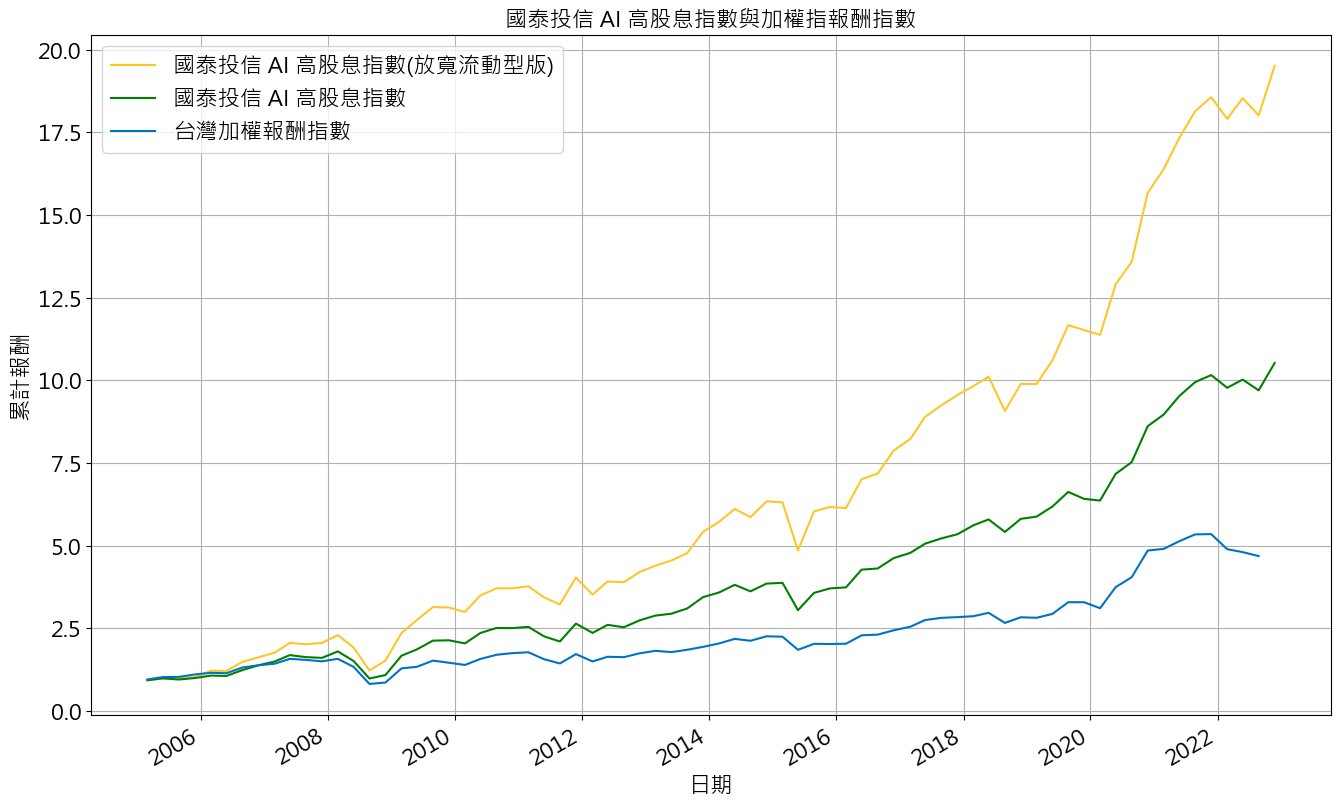

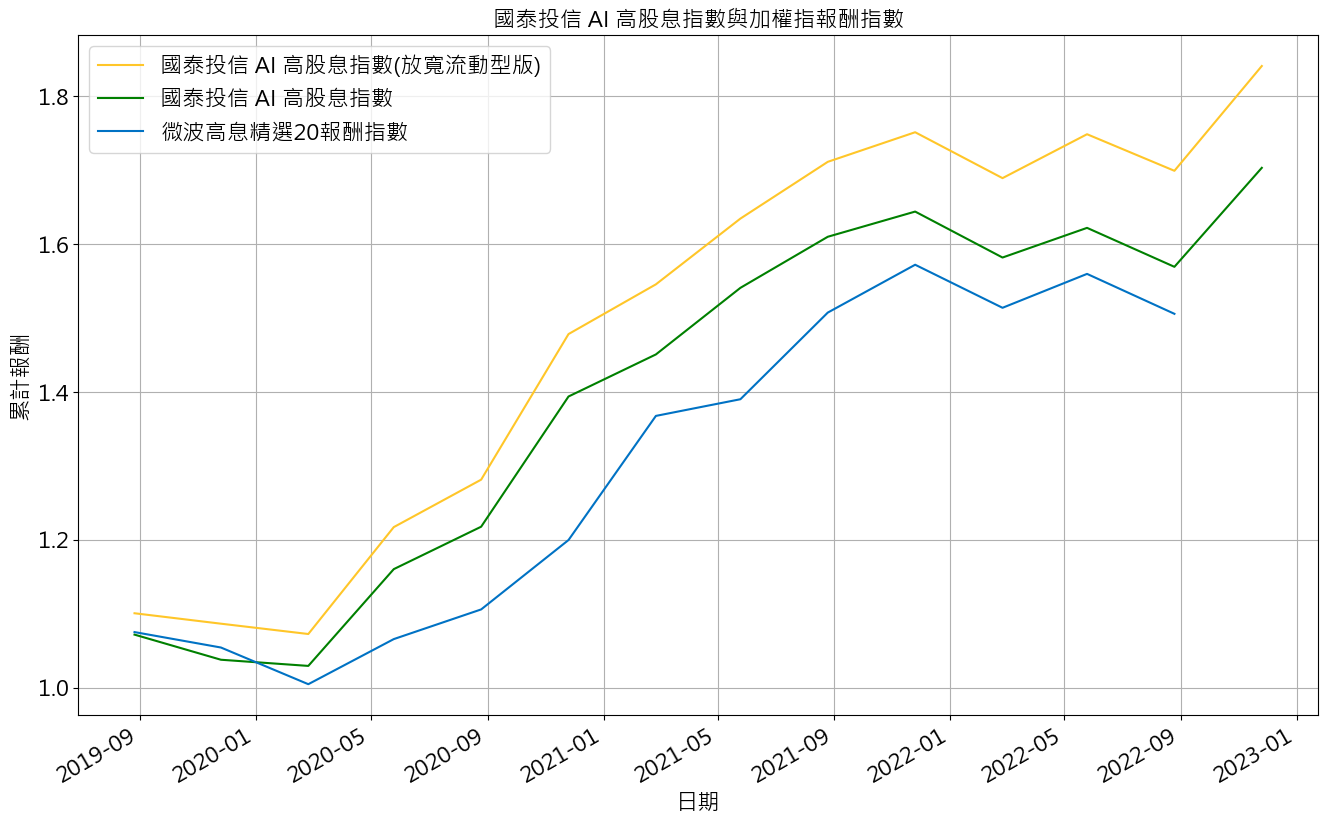

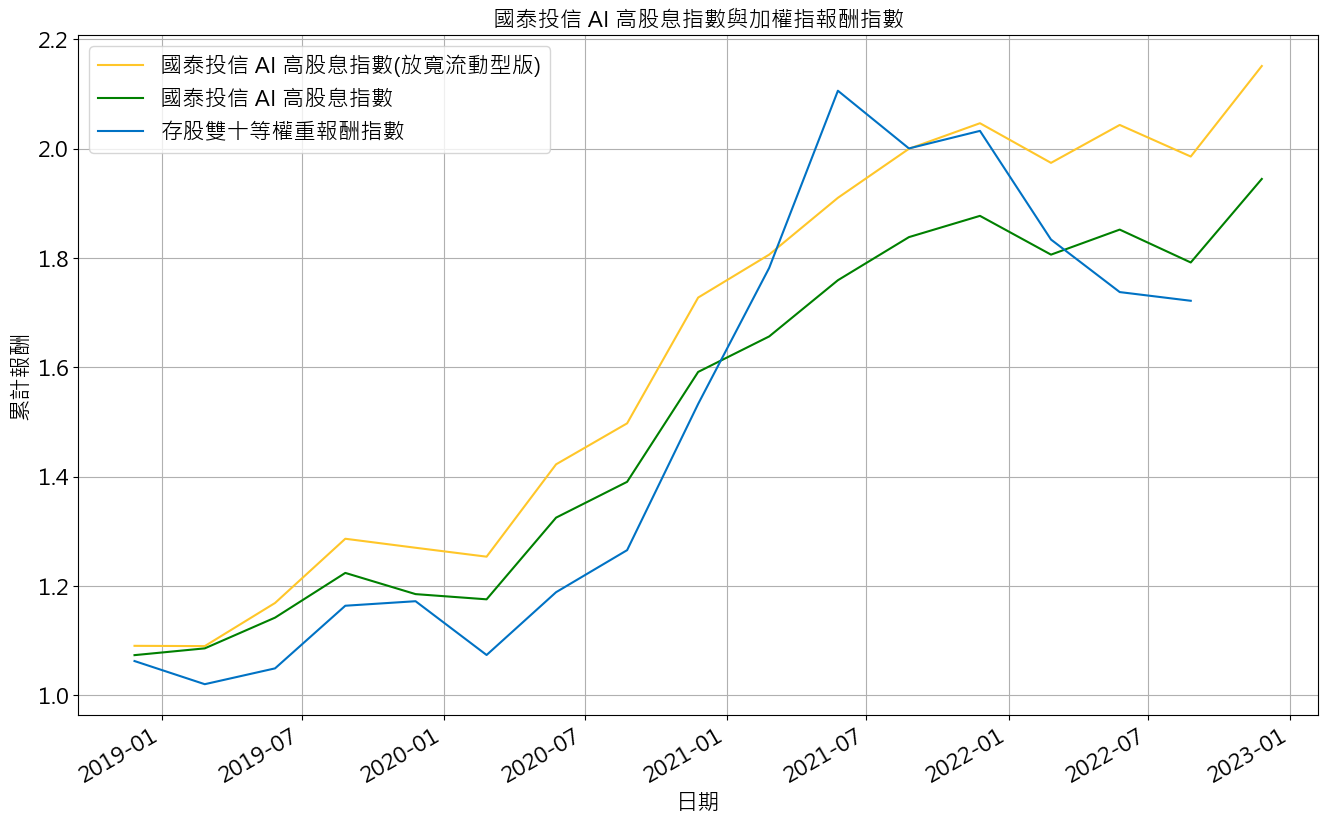

In [393]:

# figs/{model_folder_name}
# create folder if not exist
if not os.path.exists(f'./figs/{model_folder_name}'):
    os.makedirs(f'./figs/{model_folder_name}')



for index_name in benchmark_list:

    df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
    df_benchmarks_temp.columns = ['date',f'{index_name}']
    df_benchmarks_temp.dropna(inplace=True)
    # change the date format to datetime
    df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
    df_benchmarks_temp.sort_values('date', inplace=True)
    df_benchmarks = pd.merge(df_rebalance_date, df_benchmarks_temp, on='date', how='left')

    df_benchmarks = df_benchmarks.merge(df_restrict_portfolio, on='date', how='left')
    df_benchmarks = df_benchmarks.merge(df_portfolio, on='date', how='left')
    df_benchmarks.dropna(inplace=True)
    df_benchmarks.reset_index(drop=True, inplace=True)
    df_benchmarks['benchmark_adj'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
    df_benchmarks[f'{index_name}'] = df_benchmarks[f'{index_name}'].astype(float)
    # shift -1 for calculate the return
    df_benchmarks['benchmark_shift'] = df_benchmarks[f'{index_name}'].shift(-1)
    df_benchmarks['benchmark_return'] = df_benchmarks['benchmark_shift'] / df_benchmarks[f'{index_name}']

    df_benchmarks['benchmark_cumprod'] = df_benchmarks['benchmark_return'].cumprod()
    df_benchmarks['restrict_portfolio_cumprod'] = df_benchmarks['restrict_portfolio'].cumprod()
    df_benchmarks['ai_portfolio_cumprod'] = df_benchmarks['ai_portfolio'].cumprod()

    df_benchmarks.set_index('date', inplace = True)
    df_to_excel = df_benchmarks[['ai_portfolio_cumprod','restrict_portfolio_cumprod','benchmark_cumprod']].copy()
    df_to_excel.columns = ['國泰投信 AI 高股息指數(放寬流動型版)', '國泰投信 AI 高股息指數', index_name]
    df_to_excel.to_excel(f'./figs/{model_folder_name}/50檔_{index_name}.xlsx')
    df_benchmarks[['ai_portfolio_cumprod','restrict_portfolio_cumprod','benchmark_cumprod']].plot(figsize=(16,10), color=['#ffc629','green','#0072c4'])
    # df_benchmarks[['restrict_portfolio_cumprod','benchmark_cumprod']].plot(figsize=(16,10), color=['green','#0072c4'])

    # Optionally, set individual element sizes
    matplotlib.rcParams['font.size'] = 25

    plt.grid(True)
    plt.title('國泰投信 AI 高股息指數與加權指報酬指數')
    plt.xlabel('日期')
    # Set legend names
    plt.legend(['國泰投信 AI 高股息指數(放寬流動型版)', '國泰投信 AI 高股息指數', index_name])
    # plt.legend(['國泰投信 AI 高股息指數', index_name])
    plt.ylabel('累計報酬')
    plt.grid(True)
    plt.savefig(f'./figs/{model_folder_name}/放寬版_{index_name}_30.png', bbox_inches='tight')
    # plt.savefig(f'./figs/一般版_{index_name}.png', bbox_inches='tight')


# Consider Turnover

In [394]:
apply_buffer_index = 0
base_portfolio_number = 50
buffer_portfolio_number = 150

In [395]:
df_select_pool = df_select_pool.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
# get the buffer portfolio by buffer_portfolio_number
df_select_pool_buffer = df_select_pool.groupby('date').apply(top_n, n = buffer_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
df_select_pool_buffer.reset_index(drop=True, inplace=True)


apply_buffer_date = np.sort(reb_lst)[apply_buffer_index]
# string format
apply_buffer_date = pd.to_datetime(apply_buffer_date).strftime('%Y-%m-%d')
print(f'自 {apply_buffer_date} 開始使用 buffer 建構投組')

df_buffer_result = pd.DataFrame([])
# concat the data that date is smaller than apply_buffer_date to df_buffer_result
df_buffer_result = pd.concat([df_buffer_result, df_select_pool_base[df_select_pool_base['date'] < apply_buffer_date]], axis=0)
# print the max date in df_buffer_result
print(f"df_buffer_result['date'].max(): {df_buffer_result['date'].max()}")

for i in range(apply_buffer_index, len(reb_lst)):
    # get the slice data by reb_lst[i] in df_select_pool_buffer
    df_select_pool_buffer_temp = df_select_pool_buffer[df_select_pool_buffer['rebalance_date'] == reb_lst[i]].reset_index(drop=True)
    # get the slice data by reb_lst[i-1] in df_buffer_result, [i-1] is because we need to get the last portfolio
    df_buffer_result_temp = df_buffer_result[df_buffer_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_buffer_temp[['date','ticker']].copy()
    df_new_temp['buffer'] = 1
    df_old_temp = df_buffer_result_temp[['date','ticker']].copy()
    df_old_temp['last_portfolio'] = 1

    # merge the df_old_temp and df_new_temp
    df_joint_temp = pd.merge(df_old_temp[['ticker','last_portfolio']], df_new_temp[['ticker','buffer']], on=['ticker'], how='outer')
    df_joint_temp['buffer'].fillna(0, inplace=True)
    df_joint_temp['last_portfolio'].fillna(0, inplace=True)
    df_joint_temp['total'] = df_joint_temp['buffer'] + df_joint_temp['last_portfolio']
    df_joint_temp = df_joint_temp[df_joint_temp['total'] == 2]

    # get the joint ticker
    joint_ticker = df_joint_temp['ticker'].unique()

    # get the priority portfolio by joint_ticker
    df_priority = df_select_pool_buffer_temp[df_select_pool_buffer_temp['ticker'].isin(joint_ticker)]
    # get the triviality portfolio by EXCLUDING joint_ticker
    df_triviality = df_select_pool_buffer_temp[df_select_pool_buffer_temp['ticker'].isin(joint_ticker) == False]
    # then find the (top n - len(df_priority)) number of stocks triviality portfolio
    df_triviality = df_triviality.groupby('date').apply(top_n, n = base_portfolio_number - len(df_priority), columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
    
    # concat the df_priority and df_triviality
    df_buffer_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_buffer_result_temp to df_buffer_result
    df_buffer_result = pd.concat([df_buffer_result, df_buffer_result_temp], axis=0)

df_buffer_result.reset_index(drop=True, inplace=True)
# df_buffer_result_return = df_buffer_result.groupby('date')['y'].mean()
df_buffer_result_return = df_buffer_result.groupby('date')['rebalance_period_return'].mean()

df_buffer_result.to_feather(f'./data/model/{model_folder_name}/df_buffer_result_{apply_buffer_index}_{base_portfolio_number}_{buffer_portfolio_number}.feather')
print(f"SR: {((df_buffer_result_return + 1).prod()**(4/len(df_buffer_result_return)) -1 ) / (df_buffer_result_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_buffer_result_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_buffer_result_return.std() * np.sqrt(4)):.2%}")

自 2005-02-25 開始使用 buffer 建構投組
df_buffer_result['date'].max(): NaT
SR: 0.64
CAGR: 13.79%
Std: 21.48%
